In [2]:
from __future__ import print_function

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

import flotilla


flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'

study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering', flotilla_dir=flotilla_dir)

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)


/home/obotvinnik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/obotvinnik/workspace-git/flotilla/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-11-04 17:37:39	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure1_supplementary_post_splicing_filtering/datapackage.json
2016-11-04 17:37:39	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-11-04 17:38:00 	Initializing Study
2016-11-04 17:38:00 	Initializing Predictor configuration manager for Study
2016-11-04 17:38:00	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-11-04 17:38:00	Added ExtraTreesClassifier to default predictors
2016-11-04 17:38:00	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-11-04 17:38:00	Added ExtraTreesRegressor to default predictors
2016-11-04 17:38:00	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-11-04 17:38:00	Added Grad

Error loading species hg19 data: HTTP Error 404: Not Found

In [4]:
folder = 'figures/010_modality_calculation_different_expression_cutoffs' #'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities/bayesian'
! mkdir $folder

mkdir: cannot create directory `figures/010_modality_calculation_different_expression_cutoffs': File exists


In [5]:
singles_no_outliers = study.splicing.singles.ix[not_outliers].index
print(singles_no_outliers.shape)

(181,)


In [6]:
tidy_splicing = study.tidy_splicing_with_expression
print(tidy_splicing.shape)
tidy_splicing.head()

(1187483, 5)


,event_name,sample_id,psi,common_id,expression
0,exon:chr10:100190328-100190427:-@exon:chr10:10...,CVN_35,1,ENSG00000107521,7.647958
1,exon:chr10:100195392-100195529:-@exon:chr10:10...,CVN_35,1,ENSG00000107521,7.647958
2,exon:chr10:100190328-100190427:-@exon:chr10:10...,M2nd_34,0,ENSG00000107521,14.195169
3,exon:chr10:100190328-100190427:-@exon:chr10:10...,P1_06,1,ENSG00000107521,3.086260
4,exon:chr10:100193697-100193848:-@exon:chr10:10...,P1_06,1,ENSG00000107521,3.086260


In [7]:
tidy_splicing_singles = tidy_splicing.query('sample_id in @singles_no_outliers')
print(tidy_splicing_singles.shape)
tidy_splicing_singles.head()

(1013383, 5)


,event_name,sample_id,psi,common_id,expression
3,exon:chr10:100190328-100190427:-@exon:chr10:10...,P1_06,1,ENSG00000107521,3.08626
4,exon:chr10:100193697-100193848:-@exon:chr10:10...,P1_06,1,ENSG00000107521,3.08626
5,exon:chr10:100195392-100195529:-@exon:chr10:10...,P1_06,0,ENSG00000107521,3.08626
6,exon:chr10:100190328-100190427:-@exon:chr10:10...,P1_10,0,ENSG00000107521,22.27229
7,exon:chr10:100195392-100195529:-@exon:chr10:10...,P1_10,1,ENSG00000107521,22.27229


## Use only events residing in genes with corresponding gene expression log2(TPM+1) > 10

Check if expression is logged

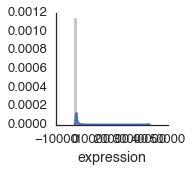

In [8]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.distplot(tidy_splicing['expression'])
sns.despine()

Nope, not logged. So need to log in our data

## Calculate/Estimate modalities only on single cells, with no outliers

And at least 10 cells per splicing event, per celltype/phenotype

In [9]:
from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR

def tidify_modalities(modality_assignments, name='event_id'):
    modalities_tidy = modality_assignments.stack().reset_index()
    modalities_tidy = modalities_tidy.rename(columns={'level_1': name, 0: "modality"})
    return modalities_tidy

def count_modalities(tidy_modalities, name='event_id'):
    modalities_counts = tidy_modalities.groupby(['phenotype', 'modality']).count().reset_index()
    modalities_counts = modalities_counts.rename(columns={name: '# AS events'})
    modalities_counts['percentage'] = 100*modalities_counts.groupby('phenotype')['# AS events'].apply(lambda x: x/x.sum())
    return modalities_counts

def count_modalities_2d(modalities_counts, index='phenotype'):
    modalities_counts_2d = modalities_counts.pivot(index=index, columns='modality', values='# AS events')
    modalities_counts_2d = modalities_counts_2d.reindex(columns=MODALITY_ORDER, index=study.phenotype_order)
    modalities_counts_2d = modalities_counts_2d.T
    return modalities_counts_2d

## Do simulations across multiple log2(TPM+1) cutoffs

In [10]:
np.log2(tidy_splicing_singles['expression']+1).describe()

count    1013383.000000
mean           6.694066
std            2.582636
min            0.000000
25%            5.593945
50%            7.084301
75%            8.351934
max           15.293171
Name: expression, dtype: float64

In [11]:
%%time

import anchor

bayesian = anchor.BayesianModalities()

cutoffs = range(1, 15)

dfs = []

for cutoff in cutoffs:
    print(cutoff)
    
    tidy_splicing_filtered = tidy_splicing.query('expression - 1 > 2**@cutoff')
    print('\ttidy_splicing_filtered.shape:', tidy_splicing_filtered.shape)
    tidy_splicing_filtered.head()
    
    tidy_splicing_filtered_no_duplicates = tidy_splicing_filtered.drop_duplicates(subset=['event_name', 'sample_id'])
    print('\ttidy_splicing_filtered_no_duplicates.shape', tidy_splicing_filtered_no_duplicates.shape)
    tidy_splicing_filtered_no_duplicates.head()
    
    splicing_2d = tidy_splicing_filtered_no_duplicates.pivot(index='sample_id', columns='event_name', values='psi')
    print('\tsplicing_2d.shape', splicing_2d.shape)
    splicing_2d.head()
    
    splicing_2d_min_samples = splicing_2d.groupby(
        study.sample_id_to_phenotype).apply(lambda x: x.dropna(thresh=study.splicing.minimum_samples, axis=1))
    print('\tsplicing_2d_min_samples.shape', splicing_2d_min_samples.shape)
    splicing_2d_min_samples.head()
    
    modality_assignments = splicing_2d_min_samples.groupby(study.sample_id_to_phenotype).apply(bayesian.fit_predict)
    
    tidy = tidify_modalities(modality_assignments)
    counts = count_modalities(tidy)
    counts['log2(TPM+1) cutoff'] = cutoff
    dfs.append(counts)
#     counts_2d = count_modalities_2d(counts)

1
	tidy_splicing_filtered.shape: (1099012, 5)
	tidy_splicing_filtered_no_duplicates.shape (977082, 5)
	splicing_2d.shape (204, 16360)
	splicing_2d_min_samples.shape (204, 13645)
2
	tidy_splicing_filtered.shape: (1090334, 5)
	tidy_splicing_filtered_no_duplicates.shape (973335, 5)
	splicing_2d.shape (204, 16360)
	splicing_2d_min_samples.shape (204, 13571)
3
	tidy_splicing_filtered.shape: (1071738, 5)
	tidy_splicing_filtered_no_duplicates.shape (961258, 5)
	splicing_2d.shape (204, 16360)
	splicing_2d_min_samples.shape (204, 13380)
4
	tidy_splicing_filtered.shape: (1030905, 5)
	tidy_splicing_filtered_no_duplicates.shape (929785, 5)
	splicing_2d.shape (204, 16360)
	splicing_2d_min_samples.shape (204, 12947)
5
	tidy_splicing_filtered.shape: (946323, 5)
	tidy_splicing_filtered_no_duplicates.shape (857926, 5)
	splicing_2d.shape (204, 16358)
	splicing_2d_min_samples.shape (204, 12074)
6
	tidy_splicing_filtered.shape: (800089, 5)
	tidy_splicing_filtered_no_duplicates.shape (728011, 5)
	splicing_

In [12]:
modality_assignments.shape

(3, 2)

In [13]:
modalities_cutoffs = pd.concat(dfs, ignore_index=True)
print(modalities_cutoffs.shape)
modalities_cutoffs.head()


(159, 5)


,phenotype,modality,# AS events,percentage,log2(TPM+1) cutoff
0,MN,bimodal,2276,27.405178,1
1,MN,excluded,1704,20.517760,1
2,MN,included,4322,52.040939,1
3,MN,uncategorized,3,0.036123,1
4,NPC,bimodal,2673,27.359263,1


In [34]:
modalities_cutoffs.max()

phenotype                      iPSC
modality              uncategorized
# AS events                    6261
% of AS events                  100
log2(TPM+1) cutoff               14
dtype: object

In [14]:
study.supplemental.modalities_different_expression_minimums = modalities_cutoffs
study.save('singlecell_pnm_figure2_modalities_cutoffs', flotilla_dir=flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_cutoffs/datapackage.json


In [37]:
sns.set(context='paper', style='whitegrid')

In [38]:
folder

'figures/010_modality_calculation_different_expression_cutoffs'

In [39]:
modalities_cutoffs = modalities_cutoffs.rename(columns={'percentage': '% of AS events'})

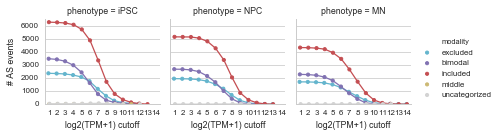

In [40]:
facetgrid = sns.factorplot(x='log2(TPM+1) cutoff', y='# AS events', data=modalities_cutoffs, 
               hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               col='phenotype', col_order=study.phenotype_order, size=2, dodge=True, scale=0.5)
facetgrid.set(ylim=(0, 6500))
facetgrid.savefig('{}/tpm_cutoff_vs_number_of_events_per_modality.pdf'.format(folder))

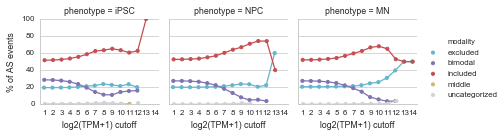

In [41]:
facetgrid = sns.factorplot(x='log2(TPM+1) cutoff', y='% of AS events', data=modalities_cutoffs, 
               hue='modality', hue_order=MODALITY_ORDER, palette=MODALITY_PALETTE,
               col='phenotype', col_order=study.phenotype_order, size=2, dodge=True, scale=0.5)
facetgrid.set(ylim=(0, 100))
facetgrid.savefig('{}/tpm_cutoff_vs_percentage_of_per_modality.pdf'.format(folder))

In [29]:
n_events_per_cutoff = modalities_cutoffs.groupby(['log2(TPM+1) cutoff', 'phenotype'])['# AS events'].sum().reset_index()
n_events_per_cutoff.head()

,log2(TPM+1) cutoff,phenotype,# AS events
0,1,MN,8305
1,1,NPC,9770
2,1,iPSC,12127
3,2,MN,8279
4,2,NPC,9747


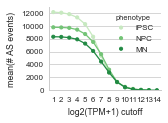

In [46]:
fig, ax = plt.subplots(figsize=(2, 1.5))
sns.pointplot(x='log2(TPM+1) cutoff', y='# AS events', hue='phenotype', data=n_events_per_cutoff, 
              palette=study.phenotype_to_color, scale=0.5, hue_order=study.phenotype_order)
sns.despine()
ax.set(ylim=(0, 13000))
fig.savefig('{}/number_of_events_per_cutoff.pdf'.format(folder))

In [47]:
study.supplemental.modalities_tpm_thresholds = modalities_cutoffs
study.save('singlecell_pnm_figure2_modalities_tpm_thresholds', flotilla_dir=flotilla_dir)

Wrote datapackage to /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_tpm_thresholds/datapackage.json
